<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-a-Layered-Network" data-toc-modified-id="Generate-a-Layered-Network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate a Layered Network</a></span><ul class="toc-item"><li><span><a href="#Apply-Labels-to-Each-Network" data-toc-modified-id="Apply-Labels-to-Each-Network-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Apply Labels to Each Network</a></span></li></ul></li><li><span><a href="#Create-other-objects-needed-for-simulation" data-toc-modified-id="Create-other-objects-needed-for-simulation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create other objects needed for simulation</a></span><ul class="toc-item"><li><span><a href="#Generate-one-Geometry-for-each-layer" data-toc-modified-id="Generate-one-Geometry-for-each-layer-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate one Geometry for each layer</a></span></li><li><span><a href="#Create-a-Phase-and-2-Physics-objects" data-toc-modified-id="Create-a-Phase-and-2-Physics-objects-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Create a Phase and 2 Physics objects</a></span></li></ul></li><li><span><a href="#Run-a-StokesFlow-simulation-in-perpendicular-directions" data-toc-modified-id="Run-a-StokesFlow-simulation-in-perpendicular-directions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Run a StokesFlow simulation in perpendicular directions</a></span><ul class="toc-item"><li><span><a href="#Determine-the-Permeability-Coefficient-for-each-direction" data-toc-modified-id="Determine-the-Permeability-Coefficient-for-each-direction-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Determine the Permeability Coefficient for each direction</a></span></li></ul></li></ul></div>

In [1]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

# Generate a Layered Network

In order to see a network with a noticable difference in permeability values in each principle direction, we'll make a network consisting of two distinct layers then stitch them together.  The process of stitching is explained in more detail [here](/examples/notebooks/networks/manipulation/stitching_and_merging_networks_together.ipynb).

In [2]:
pn = op.network.Cubic(shape=[8, 8, 8], spacing=30e-6)
pn2 = op.network.Cubic(shape=[24, 24, 8], spacing=10e-6)

## Apply Labels to Each Network

In order to make it easier to find pore indices after stitching, it's helpful to apply unique and descriptive labels to the networks first. Labels are discussed detail [here](/examples/notebooks/tutorials/using_and_creating_labels.ipynb).

In [3]:
pn['pore.coarse'] = True
pn['throat.coarse'] = True
pn2['pore.fine'] = True
pn2['throat.fine'] = True

Now we can stitch the two network together, but first we must translate the fine network along the z-axis so the networks are not overlapping.  Stiching is described in more detail [here](.../tutorials/manipulation/stitching_and_merging_networks_together.ipynb).

In [4]:
pn2['pore.coords'] += [0, 0, 8*30e-6]
op.topotools.stitch(network=pn, donor=pn2, P_network=pn.pores('top'), P_donor=pn2.pores('bottom'))

Let's visualize the network to see if it stitched as expected. Quick plotting is described in more detail [here](/examples/notebooks/io/quick_plotting_networks.ipynb).

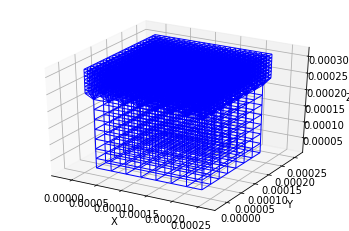

In [5]:
fig = op.topotools.plot_connections(pn)

# Create other objects needed for simulation
## Generate one Geometry for each layer

In [6]:
Ps = pn.pores('fine')
Ts = pn.throats('fine')
geo2 = op.geometry.StickAndBall(network=pn, pores=Ps, throats=Ts)
Ps = pn.pores('coarse')
Ts = pn.throats(['coarse', 'stitched'])
geo1 = op.geometry.StickAndBall(network=pn, pores=Ps, throats=Ts)

Let's visualize the pore sizes using histograms:

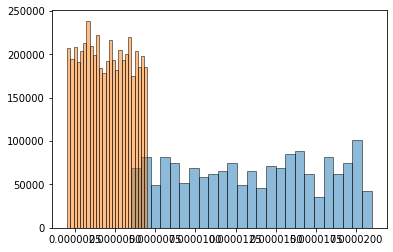

In [7]:
fig = plt.hist(geo1['pore.diameter'], bins=25, density=True, edgecolor='k', alpha=0.5)
fig = plt.hist(geo2['pore.diameter'], bins=25, density=True, edgecolor='k', alpha=0.5)

## Create a Phase and 2 Physics objects

In [8]:
air = op.phases.Air(network=pn)
phys1 = op.physics.Standard(network=pn, phase=air, geometry=geo1)
phys2 = op.physics.Standard(network=pn, phase=air, geometry=geo2)

Let's visualize the hydraulic conductances using histograms.  Note that the values are logged, to better visualize the distributions:

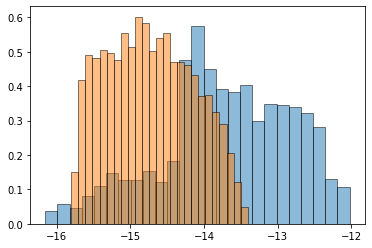

In [9]:
fig = plt.hist(np.log10(phys1['throat.hydraulic_conductance']), bins=25, density=True, edgecolor='k', alpha=0.5)
fig = plt.hist(np.log10(phys2['throat.hydraulic_conductance']), bins=25, density=True, edgecolor='k', alpha=0.5)

# Run a StokesFlow simulation in perpendicular directions

In [10]:
sf_x = op.algorithms.StokesFlow(network=pn, phase=air)
Pin = 1.0
Pout = 0.0
sf_x.set_value_BC(pores=pn.pores('left'), values=1.0)
sf_x.set_value_BC(pores=pn.pores('right'), values=0.0)
sf_x.run()

Let's make sure the pressure field is applied in the correct direction:

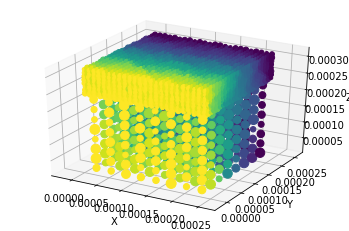

In [11]:
fig = op.topotools.plot_coordinates(pn, color=sf_x['pore.pressure'], size_by=pn['pore.diameter'], markersize=100)

In [12]:
sf_z = op.algorithms.StokesFlow(network=pn, phase=air)
Pin = 1.0
Pout = 0.0
sf_z.set_value_BC(pores=pn.pores(['top', 'coarse'], mode='and'), values=Pin)
sf_z.set_value_BC(pores=pn.pores(['top', 'fine'], mode='and'), values=Pout)
sf_z.run()

Again, let's visualize the pressure field:

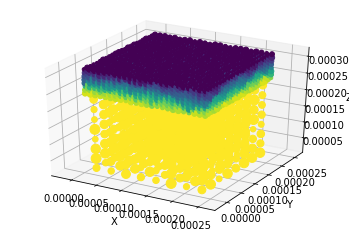

In [13]:
fig = op.topotools.plot_coordinates(pn, color=sf_z['pore.pressure'], size_by=pn['pore.diameter'], markersize=100)

The presure in the coarse network is essentially constant since it's much more permeable than the fine layer.

## Determine the Permeability Coefficient for each direction

In [14]:
L = 8 * 30e-6
A = (8 * 30e-6)**2 + (8 * 24)*(10e-6)**2
mu = air['pore.viscosity'][0]
Q = sf_x.rate(pores=pn.pores('left'), mode='group')
Kx = Q*L*mu/(A*(Pin - Pout))
print('The permeability coefficient is:', Kx)

The permeability coefficient is: [5.06285586e-14]


In [15]:
A = (8 * 30e-6)**2
L = (8 * 30e-6) + (8 * 10e-6)
mu = air['pore.viscosity'][0]
Q = sf_z.rate(pores=pn.pores(['top', 'coarse'], mode='and'), mode='group')
Kz = Q*L*mu/(A*(Pin - Pout))
print('The permeability coefficient is:', Kz)

The permeability coefficient is: [2.41258976e-14]


In [16]:
Kx/Kz

array([2.09851503])

The permeability coefficient for the direction through the 'fine' layer is about 2x lower than the direction parallel to it.  